In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore, linregress
from pandas.plotting import scatter_matrix

Prepare flux data


In [2]:
ec = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/AMF_US-Ha1_FLUXNET_SUBSET_DD_1991-2020_3-5.csv"
)
ec["t"] = pd.to_datetime(ec["TIMESTAMP"], format="%Y%m%d")
ec = ec.set_index("t")
gpp = ec[["GPP_NT_VUT_REF"]]
par = ec[["PPFD_IN"]]
par_qc = ec[["PPFD_IN_QC"]]
ec_daily = pd.concat([gpp, par, par_qc], axis=1).rename(
    columns={"GPP_NT_VUT_REF": "gpp", "PPFD_IN": "par", "PPFD_IN_QC": "par_qc"}
)

ec_daily = ec_daily[ec_daily["par_qc"] == 1]
ec_daily

,gpp,par,par_qc
t,,,
1991-10-28,1.026900,267.791667,1.0
1991-10-29,1.024950,283.500000,1.0
1991-10-30,1.374350,247.375000,1.0
1991-10-31,0.584442,60.250000,1.0
1991-11-01,1.491380,72.958333,1.0
...,...,...,...
2020-12-27,-0.095248,184.258333,1.0
2020-12-28,0.201202,57.445833,1.0
2020-12-29,-0.238175,155.670833,1.0


Prepare MODIS data FPAR


In [3]:
fpar = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/MODIS_DATA/US-Ha1-MYD15A2H-061-results.csv"
)
# filter based on QC flags
filtered_fpar = fpar[
    (fpar["MYD15A2H_061_FparLai_QC_MODLAND"] == "0b0")
    & (fpar["MYD15A2H_061_FparLai_QC_DeadDetector"] == "0b0")
    & (fpar["MYD15A2H_061_FparLai_QC_CloudState"] == "0b00")
    & (fpar["MYD15A2H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
].copy()
filtered_fpar.loc[:, "time"] = pd.to_datetime(filtered_fpar["Date"])

In [4]:
fpar_8days = filtered_fpar[["MYD15A2H_061_Fpar_500m"]]
fpar_8days.set_index(filtered_fpar["time"], inplace=True)
fpar_8days

,MYD15A2H_061_Fpar_500m
time,
2002-07-12,0.93
2002-07-20,0.92
2002-07-28,0.66
2002-08-05,0.92
2002-08-13,0.92
...,...
2023-12-03,0.39
2023-12-11,0.35
2023-12-19,0.46


In [5]:
# Resample the dataframe to daily frequency
fpar_daily = fpar_8days.resample("D").interpolate(method="linear")
fpar_daily.rename(columns={"MYD15A2H_061_Fpar_500m": "fpar"}, inplace=True)
fpar_daily

,fpar
time,
2002-07-12,0.93000
2002-07-13,0.92875
2002-07-14,0.92750
2002-07-15,0.92625
2002-07-16,0.92500
...,...
2023-12-28,0.46000
2023-12-29,0.46000
2023-12-30,0.46000


In [65]:
refl = pd.read_csv(
    "../data/EC/AMF_US-Ha1_FLUXNET_SUBSET_1991-2020_3-5/MODIS_DATA/US-Ha-brdf-reflec-MCD43A4-061-results.csv"
)
# filter based on QC flags
filtered_refl = refl[
    (refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"] == "0b000")
    & (refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"] == "0b000")
    & (refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band4_MODLAND"] == "0b000")
].copy()
filtered_refl.loc[:, "time"] = pd.to_datetime(filtered_refl["Date"])
filtered_refl

,Category,ID,Latitude,Longitude,Date,MODIS_Tile,MCD43A4_061_Line_Y_500m,MCD43A4_061_Sample_X_500m,MCD43A4_061_Nadir_Reflectance_Band1,MCD43A4_061_Nadir_Reflectance_Band2,...,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band6_MODLAND,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band6_MODLAND_Description,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band6_Fill,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band6_Fill_Description,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_bitmask,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_MODLAND,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_MODLAND_Description,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_Fill,MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band7_Fill_Description,time
0,DBF,US-Ha1,42.5378,-72.1715,2002-01-01,h12v04,1790.0,1637.0,0.0340,0.1797,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-01-01
1,DBF,US-Ha1,42.5378,-72.1715,2002-01-02,h12v04,1790.0,1637.0,0.0342,0.1800,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-01-02
2,DBF,US-Ha1,42.5378,-72.1715,2002-01-03,h12v04,1790.0,1637.0,0.0341,0.1801,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-01-03
94,DBF,US-Ha1,42.5378,-72.1715,2002-04-05,h12v04,1790.0,1637.0,0.0432,0.2039,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-04-05
95,DBF,US-Ha1,42.5378,-72.1715,2002-04-06,h12v04,1790.0,1637.0,0.0435,0.2045,...,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2002-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7992,DBF,US-Ha1,42.5378,-72.1715,2023-11-20,h12v04,1790.0,1637.0,0.0400,0.1686,...,0b001,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2023-11-20
7993,DBF,US-Ha1,42.5378,-72.1715,2023-11-21,h12v04,1790.0,1637.0,0.0347,0.1454,...,0b001,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2023-11-21
7994,DBF,US-Ha1,42.5378,-72.1715,2023-11-22,h12v04,1790.0,1637.0,0.0346,0.1451,...,0b001,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2023-11-22
7995,DBF,US-Ha1,42.5378,-72.1715,2023-11-23,h12v04,1790.0,1637.0,0.0343,0.1456,...,0b001,"Processed, good quality (full BRDF inversions)",0b00000,NaN,0b00000000,0b000,"Processed, good quality (full BRDF inversions)",0b00000,NaN,2023-11-23


In [68]:
red_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band1"]]
nir_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band2"]]
green_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band4"]]

refl_daily = pd.concat([red_daily, nir_daily, green_daily], axis=1).rename(
    {
        "MCD43A4_061_Nadir_Reflectance_Band1": "red",
        "MCD43A4_061_Nadir_Reflectance_Band2": "nir",
        "MCD43A4_061_Nadir_Reflectance_Band4": "green",
    },
    axis=1,
)
refl_daily.set_index(filtered_refl["time"], inplace=True)
refl_daily

,red,nir,green
time,,,
2002-01-01,0.0340,0.1797,0.0313
2002-01-02,0.0342,0.1800,0.0313
2002-01-03,0.0341,0.1801,0.0313
2002-04-05,0.0432,0.2039,0.0366
2002-04-06,0.0435,0.2045,0.0368
...,...,...,...
2023-11-20,0.0400,0.1686,0.0342
2023-11-21,0.0347,0.1454,0.0311
2023-11-22,0.0346,0.1451,0.0310


In [69]:
# Merge the dataframes on the index (dates)
daily_df = ec_daily.merge(refl_daily, left_index=True, right_index=True).merge(
    fpar_daily, left_index=True, right_index=True
)
daily_df

,gpp,par,par_qc,red,nir,green,fpar
2002-07-12,13.488000,644.254167,1.0,0.0202,0.4024,0.0437,0.93000
2002-07-13,13.756500,643.283333,1.0,0.0213,0.4041,0.0449,0.92875
2002-07-14,13.306100,594.245833,1.0,0.0196,0.4014,0.0431,0.92750
2002-07-15,12.994600,411.725000,1.0,0.0198,0.4005,0.0434,0.92625
2002-07-16,15.192200,577.966667,1.0,0.0198,0.4004,0.0433,0.92500
...,...,...,...,...,...,...,...
2020-11-13,-0.168021,35.470833,1.0,0.0414,0.1733,0.0346,0.47500
2020-11-14,-0.087693,109.866667,1.0,0.0410,0.1698,0.0338,0.47000
2020-11-15,-0.041997,110.362500,1.0,0.0411,0.1668,0.0330,0.46500
2020-11-16,-0.302262,123.416667,1.0,0.0340,0.1619,0.0319,0.46000


In [78]:
w_nir = 0.9789
w_green = 0.4898
daily_df.loc[:, "ndvi"] = (daily_df["nir"] - daily_df["red"]) / (
    daily_df["nir"] + daily_df["red"]
)
daily_df.loc[:, "nirv"] = daily_df["ndvi"] * daily_df["nir"]
daily_df.loc[:, "nirvp"] = daily_df["nirv"] * daily_df["par"]
daily_df.loc[:, "fesc"] = daily_df["nirv"] / daily_df["fpar"]
daily_df.loc[:, "lue"] = daily_df["gpp"] / (daily_df["par"] * daily_df["fpar"])
daily_df.loc[:, "p"] = ((daily_df["nir"] / w_nir) - (daily_df["green"] / w_green)) / (
    daily_df["nir"] - daily_df["green"]
)

daily_df.head()

,gpp,par,par_qc,red,nir,green,fpar,ndvi,nirv,nirvp,fesc,lue,p
2002-07-12,13.4880,644.254167,1.0,0.0202,0.4024,0.0437,0.93000,0.904401,0.363931,234.464123,0.391324,0.022512,0.897278
2002-07-13,13.7565,643.283333,1.0,0.0213,0.4041,0.0449,0.92875,0.899859,0.363633,233.919051,0.391529,0.023025,0.894043
2002-07-14,13.3061,594.245833,1.0,0.0196,0.4014,0.0431,0.92750,0.906888,0.364025,216.320332,0.392480,0.024142,0.898847
2002-07-15,12.9946,411.725000,1.0,0.0198,0.4005,0.0434,0.92625,0.905782,0.362766,149.359636,0.391650,0.034074,0.897578
2002-07-16,15.1922,577.966667,1.0,0.0198,0.4004,0.0433,0.92500,0.905759,0.362666,209.608841,0.392071,0.028417,0.897864


In [79]:
# Calculate Z-scores
z_scores = np.abs(zscore(daily_df))

# Set a threshold for outliers
threshold = 3

# Get a boolean mask where True indicates it is an outlier
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers
daily_df_no_outliers = daily_df[~outliers].copy()

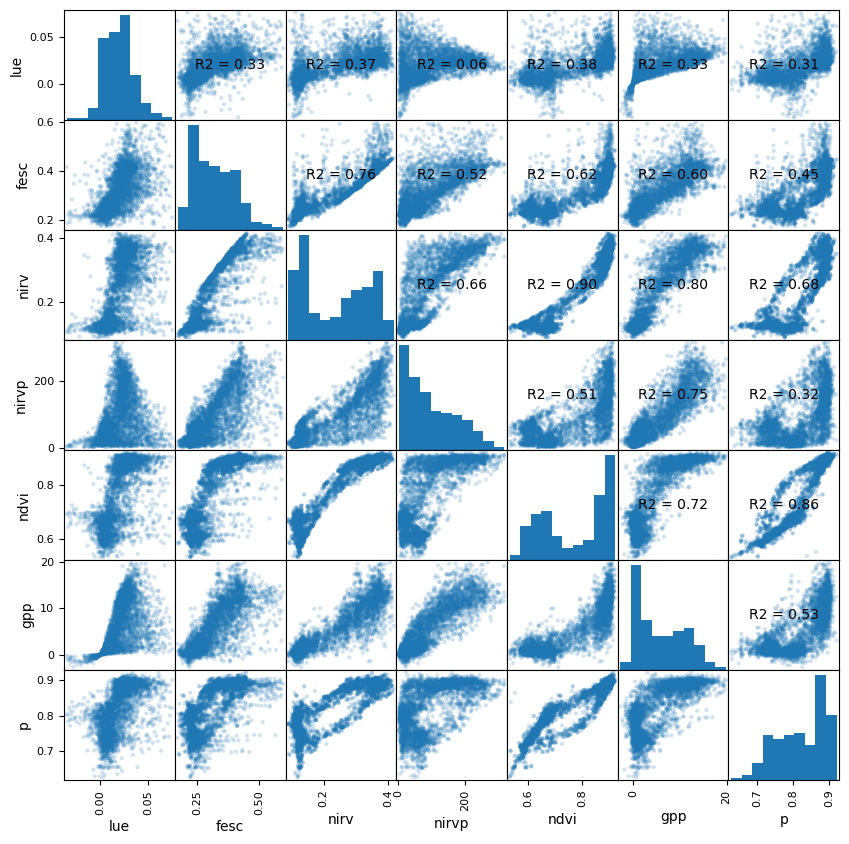

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pandas.plotting import scatter_matrix

attributes = ["lue", "fesc", "nirv", "nirvp", "ndvi", "gpp", "p"]
axs = scatter_matrix(daily_df_no_outliers[attributes], figsize=(10, 10), alpha=0.2)

r2_values = {}
p_values = {}

for i, x in enumerate(attributes):
    for j, y in enumerate(attributes):
        if i < j:
            slope, intercept, r_value, p_value, std_err = linregress(
                daily_df_no_outliers[x], daily_df_no_outliers[y]
            )
            r2_values[(x, y)] = r_value**2
            p_values[(x, y)] = p_value

            # Annotate the cell with the R2 value
            ax = axs[i, j]
            ax.annotate(
                f"R2 = {r_value**2:.2f}",
                (0.5, 0.5),
                xycoords="axes fraction",
                ha="center",
                va="center",
            )

plt.savefig("../outputs/daily_harvard_scatter.png")

In [95]:
# REsample to weekly
weekly_df = daily_df_no_outliers.resample("W").mean()

# Calculate Z-scores
z_scores = np.abs(zscore(weekly_df))

# Set a threshold for outliers
threshold = 3

# Get a boolean mask where True indicates it is an outlier
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers
weekly_df_no_outliers = weekly_df[~outliers].copy()
weekly_df_no_outliers.dropna(inplace=True)
weekly_df_no_outliers

,gpp,par,par_qc,red,nir,green,fpar,ndvi,nirv,nirvp,fesc,lue,p
2002-07-14,13.516867,627.261111,1.0,0.020367,0.402633,0.043900,0.928750,0.903716,0.363863,228.234502,0.391778,0.023226,0.896723
2002-07-21,12.879953,453.441667,1.0,0.020000,0.397957,0.042429,0.918036,0.904287,0.359873,163.326856,0.392040,0.032388,0.899827
2002-08-04,17.352400,562.337500,1.0,0.021600,0.363050,0.042250,0.790000,0.887445,0.322290,181.362329,0.412074,0.039818,0.886805
2002-08-11,13.100643,528.850000,1.0,0.019857,0.378657,0.040957,0.920000,0.900359,0.340924,180.618355,0.370569,0.027521,0.897796
2002-08-18,12.070571,485.128571,1.0,0.019414,0.380443,0.040286,0.901250,0.902903,0.343500,166.702130,0.381266,0.027826,0.900746
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-25,0.910910,188.230208,1.0,0.042150,0.225425,0.041275,0.573438,0.684733,0.154417,28.895190,0.269295,0.009468,0.792763
2020-11-01,0.069585,166.470833,1.0,0.045167,0.184467,0.038600,0.576458,0.606680,0.111905,18.871207,0.194146,-0.000638,0.751575
2020-11-08,0.688137,239.642262,1.0,0.041943,0.184171,0.037371,0.530000,0.629100,0.115848,27.706440,0.218749,0.005389,0.761917
2020-11-15,0.312798,126.781548,1.0,0.039957,0.173743,0.034600,0.480000,0.625879,0.108792,13.967137,0.226551,0.004703,0.767903


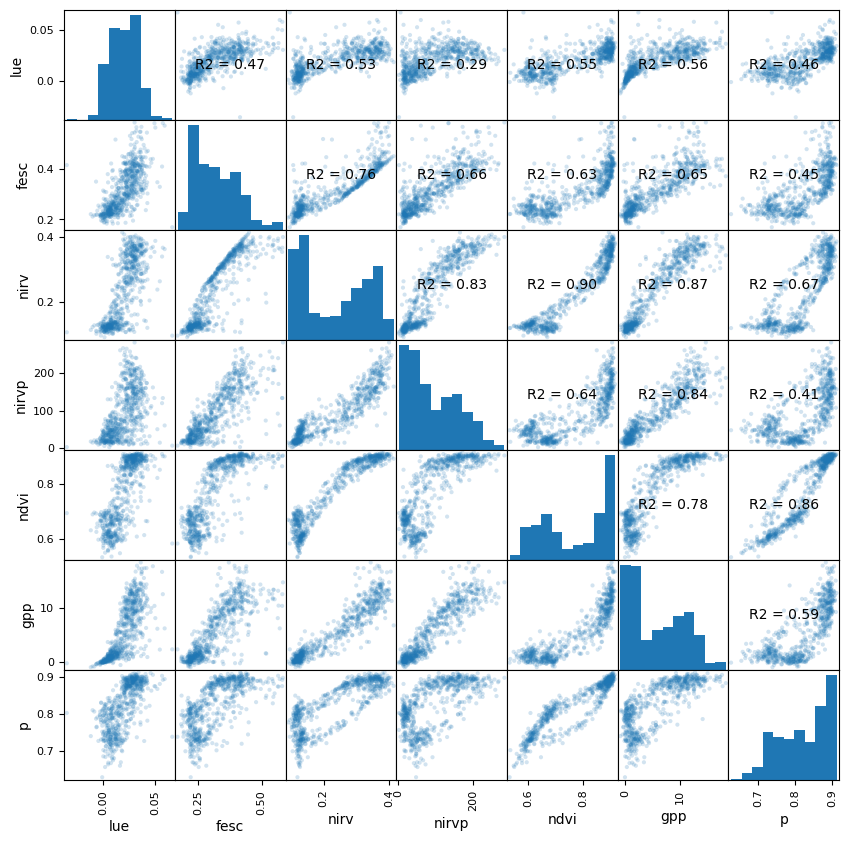

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pandas.plotting import scatter_matrix

attributes = ["lue", "fesc", "nirv", "nirvp", "ndvi", "gpp", "p"]
axs = scatter_matrix(weekly_df_no_outliers[attributes], figsize=(10, 10), alpha=0.2)

r2_values = {}
p_values = {}

for i, x in enumerate(attributes):
    for j, y in enumerate(attributes):
        if i < j:
            slope, intercept, r_value, p_value, std_err = linregress(
                weekly_df_no_outliers[x], weekly_df_no_outliers[y]
            )
            r2_values[(x, y)] = r_value**2
            p_values[(x, y)] = p_value

            # Annotate the cell with the R2 value
            ax = axs[i, j]
            ax.annotate(
                f"R2 = {r_value**2:.2f}",
                (0.5, 0.5),
                xycoords="axes fraction",
                ha="center",
                va="center",
            )

plt.savefig("../outputs/weekly_harvard_scatter.png")

In [97]:
# Resample the dataframe to monthly frequency
monthly_df = daily_df_no_outliers.resample("M").mean()

# Calculate Z-scores
z_scores = np.abs(zscore(monthly_df))

# Set a threshold for outliers
threshold = 3

# Get a boolean mask where True indicates it is an outlier
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers
monthly_df_no_outliers = monthly_df[~outliers].copy()
monthly_df_no_outliers.dropna(inplace=True)
monthly_df_no_outliers

,gpp,par,par_qc,red,nir,green,fpar,ndvi,nirv,nirvp,fesc,lue,p
2002-07-31,13.478379,509.914773,1.0,0.020336,0.394955,0.042927,0.900455,0.901831,0.356285,181.692171,0.396819,0.031110,0.896923
2002-08-31,12.476890,506.513235,1.0,0.019824,0.377976,0.040659,0.906397,0.900299,0.340309,172.634419,0.375594,0.027451,0.898544
2002-09-30,8.155929,338.308611,1.0,0.021763,0.335837,0.039207,0.897083,0.878095,0.294965,100.280265,0.328873,0.030129,0.886601
2002-10-31,2.882929,228.674256,1.0,0.034957,0.279961,0.041871,0.765446,0.774553,0.218281,50.634228,0.283567,0.019577,0.838472
2002-11-30,0.293693,161.858056,1.0,0.037687,0.228300,0.036540,0.595750,0.716365,0.163682,26.465044,0.277915,0.004567,0.826705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,10.621717,593.614312,1.0,0.028778,0.395757,0.051048,0.902582,0.864175,0.342113,203.840529,0.379090,0.020621,0.870355
2020-08-31,8.074398,482.386859,1.0,0.025127,0.382431,0.043992,0.894159,0.876202,0.335339,161.354251,0.374802,0.021416,0.888114
2020-09-30,5.865301,422.037292,1.0,0.028165,0.325760,0.044220,0.866750,0.839901,0.273949,115.891272,0.322929,0.018324,0.860226
2020-10-31,1.195978,268.396354,1.0,0.039954,0.251400,0.042346,0.525052,0.721653,0.182763,50.427440,0.357066,0.008398,0.811723


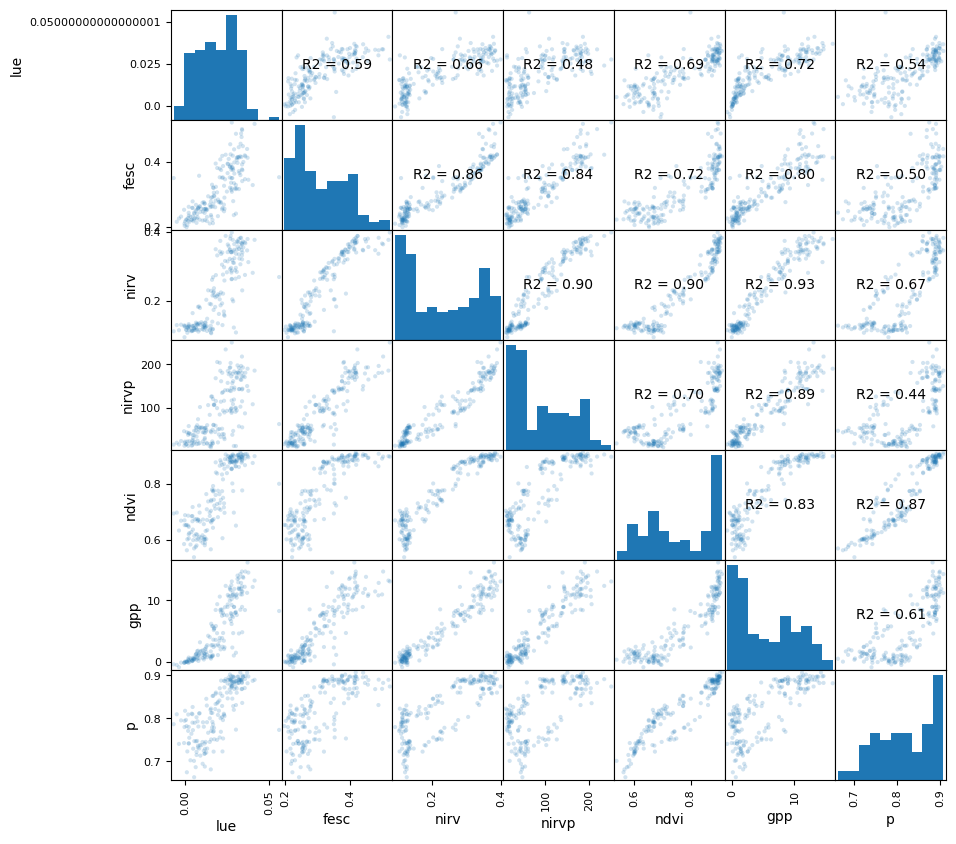

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pandas.plotting import scatter_matrix

attributes = ["lue", "fesc", "nirv", "nirvp", "ndvi", "gpp", "p"]
axs = scatter_matrix(monthly_df_no_outliers[attributes], figsize=(10, 10), alpha=0.2)

r2_values = {}
p_values = {}

for i, x in enumerate(attributes):
    for j, y in enumerate(attributes):
        if i < j:
            slope, intercept, r_value, p_value, std_err = linregress(
                monthly_df_no_outliers[x], monthly_df_no_outliers[y]
            )
            r2_values[(x, y)] = r_value**2
            p_values[(x, y)] = p_value

            # Annotate the cell with the R2 value
            ax = axs[i, j]
            ax.annotate(
                f"R2 = {r_value**2:.2f}",
                (0.5, 0.5),
                xycoords="axes fraction",
                ha="center",
                va="center",
            )

plt.savefig("../outputs/monthly_harvard_scatter.png")

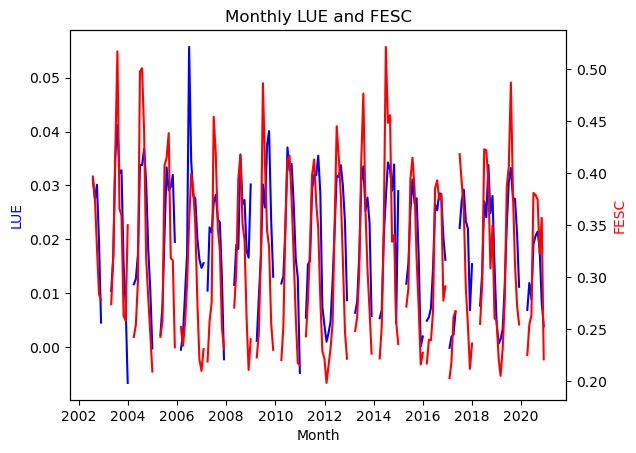

In [101]:
fig, ax1 = plt.subplots()

# Plot 'lue' on the first axis
ax1.plot(monthly_df.index, monthly_df["lue"], color="blue")
ax1.set_xlabel("Month")
ax1.set_ylabel("LUE", color="blue")

# Create a second axis
ax2 = ax1.twinx()

# Plot 'fesc' on the second axis
ax2.plot(monthly_df.index, monthly_df["fesc"], color="red")
ax2.set_ylabel("FESC", color="red")

plt.title("Monthly LUE and FESC")
plt.savefig("../outputs/monthly_lue_fesc_TS.png")

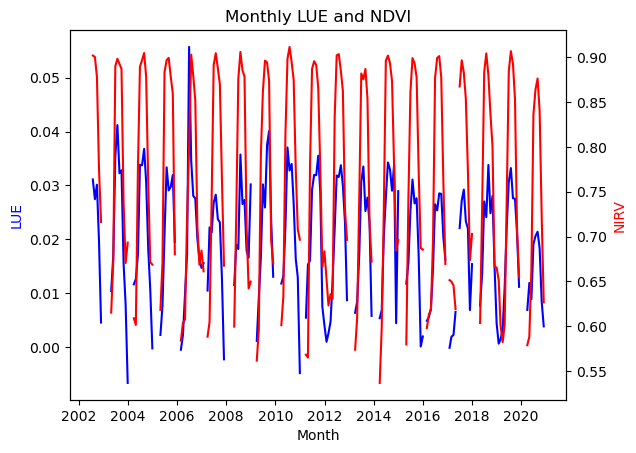

In [122]:
fig, ax1 = plt.subplots()

# Plot 'lue' on the first axis
ax1.plot(monthly_df.index, monthly_df["lue"], color="blue")
ax1.set_xlabel("Month")
ax1.set_ylabel("LUE", color="blue")

# Create a second axis
ax2 = ax1.twinx()

# Plot 'fesc' on the second axis
ax2.plot(monthly_df.index, monthly_df["ndvi"], color="red")
ax2.set_ylabel("NIRV", color="red")

plt.title("Monthly LUE and NDVI")
plt.savefig("../outputs/monthly_lue_ndvi_TS.png")

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Assuming `ts` is your pandas Series or DataFrame
result = adfuller(daily_df_no_outliers["lue"].values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print("Critical Values:")
    print(f"   {key}, {value}")

2002-07-12    0.022512
2002-07-13    0.023025
2002-07-14    0.024142
2002-07-15    0.034074
2002-07-16    0.028417
                ...   
2020-11-13   -0.009972
2020-11-14   -0.001698
2020-11-15   -0.000818
2020-11-16   -0.005324
2020-11-17   -0.007267
Name: lue, Length: 3820, dtype: float64

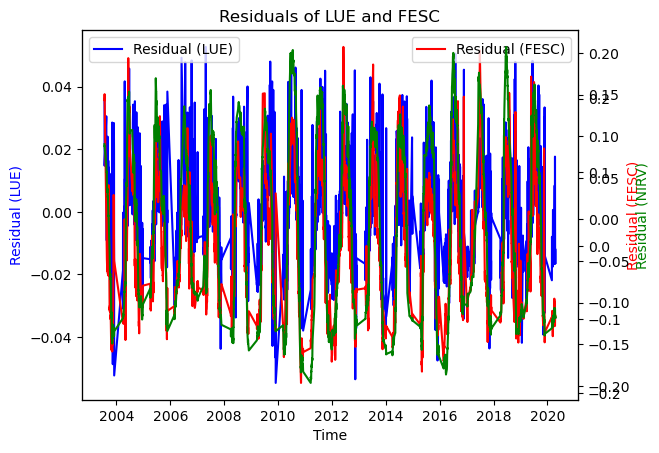

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_lue = seasonal_decompose(daily_df_no_outliers["lue"], model='additive', period=365)
decomposition_fesc = seasonal_decompose(daily_df_no_outliers["fesc"], model='additive', period=365)
decomposition_nirv = seasonal_decompose(daily_df_no_outliers["nirv"], model='additive', period=365)
fig, ax1 = plt.subplots()

# Plot the residuals of decomposition_lue on the first axis
ax1.plot(decomposition_lue.resid, label='Residual (LUE)', color='blue')
ax1.set_ylabel('Residual (LUE)', color='blue')

# Create a second axis
ax2 = ax1.twinx()

# Plot the residuals of decomposition_fesc on the second axis
ax2.plot(decomposition_fesc.resid, label='Residual (FESC)', color='red')
ax2.set_ylabel('Residual (FESC)', color='red')

ax3 = ax1.twinx()
ax3.plot(decomposition_nirv.resid, label='Residual (NIRV)', color='green')
ax3.set_ylabel('Residual (NIRV)', color='green')

# Set labels and title
ax1.set_xlabel('Time')
plt.title('Residuals of LUE and FESC')

# Display the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


In [116]:
trend_lue = decomposition_lue.resid.dropna()
trend_fesc = decomposition_fesc.resid.dropna()
trend_nirv = decomposition_nirv.resid.dropna()

# Calculate correlation coefficients
corr_fesc = trend_lue.corr(trend_fesc)
corr_nirv = trend_lue.corr(trend_nirv)
print("Correlation coefficient between LUE trend and FESC trend:", corr_fesc)
print("Correlation coefficient between LUE trend and NIRV trend:", corr_nirv)

Correlation coefficient between LUE trend and FESC trend: 0.6173157663873113
Correlation coefficient between LUE trend and NIRV trend: 0.6475315526317774


In [117]:

# Extract seasonal components
seasonal_lue = decomposition_lue.seasonal.dropna()
seasonal_fesc = decomposition_fesc.seasonal.dropna()
seasonal_nirv = decomposition_nirv.seasonal.dropna()

# Calculate correlation coefficients
corr_fesc_seasonal = seasonal_lue.corr(seasonal_fesc)
corr_nirv_seasonal = seasonal_lue.corr(seasonal_nirv)

# Output correlation coefficients
print("Correlation coefficient between LUE seasonal cycle and FESC seasonal cycle:", corr_fesc_seasonal)
print("Correlation coefficient between LUE seasonal cycle and NIRV seasonal cycle:", corr_nirv_seasonal)

Correlation coefficient between LUE seasonal cycle and FESC seasonal cycle: 0.6143405414232271
Correlation coefficient between LUE seasonal cycle and NIRV seasonal cycle: 0.6159158361860797


In [ ]:
# interannual variabolity,
# seasonal variability,
# trend,
# anomalies